# QOSF Mentorship Program Application Cohort 7

## Summary

**Applicant** : Mohammad Shoaib

**Choosen Task** : Task 3 QSVM


**Task Description**:
Generate a Quantum Support Vector Machine (QSVM) using the iris dataset and try to propose a kernel from a parametric quantum circuit to classify the three classes(setosa, versicolor, virginica) using the one-vs-all format, the kernel only works as binary classification. Identify the proposal with the lowest number of qubits and depth to obtain higher accuracy. You can use the UU† format or using the Swap-Test.

#### **Results**
I have used k-fold cross validation (without it, it's possible to get 100% accuracy using certain seeds in train_test_split) to analyze the performance of different quantum kernels. The mean accuracy and std are given in the following table-

| Features | Feature Map | Library/SDK | Number of Qubits | Depth | Mean Accuracy | STD |
| :---: | :---: | :---: | :---: | :---: | :---: | :---: | 
| All | ZFeatureMap | Qiskit | 4 | 2 | 0.967 | 0.021|
| All | ZZFeatureMap | Qiskit | 4 | 11 | 0.967 | 0.021|
| Petal Length & Width | Angle Encoding | Pennylane | 2 | 2 | 0.96 | 0.025|
| Petal Length & Width | ZZFeatureMap | Qiskit | 2 | 5 | 0.96 | 0.025|
| All | Angle Encoding | Pennylane | 4 | 2 | 0.96 | 0.025|
| Petal Length & Width | Classic | scikit-learn | NA | NA | 0.96 | 0.044|
| All | Classic | scikit-learn | NA | NA | 0.96 | 0.061|
| Reduced by PCA(2) | Classic | scikit-learn | NA | NA | 0.953 | 0.043|
| Reduced by PCA(2) | Angle Encoding | Pennylane | 2 | 2 | 0.927 | 0.033|
| Reduced by PCA(2) | ZZFeatureMap | Qiskit | 2 | 5 | 0.92 | 0.034|
| Sepal Length & Width | Angle Encoding | Pennylane | 2 | 2 | 0.807 | 0.074|
| Sepal Length & Width | ZZFeatureMap | Qiskit | 2 | 5 | 0.8 | 0.047|
| Sepal Length & Width | Classic | scikit-learn | NA | NA | 0.78 | 0.085|
| All | Amplitude Encoding | Pennylane | 4 | 5 | 0.773 | 0.102|
| Sepal Length & Width | Amplitude Encoding | Pennylane | 2 | 2 | 0.7 | 0.047|
| Petal Length & Width | Amplitude Encoding | Pennylane | 2 | 2 | 0.64 | 0.053|
| Reduced by PCA(2) | Amplitude Encoding | Pennylane | 2 | 3 | 0.58 | 0.098|

#### **Highest performance**

The QSMV model which uses all 4 features with ZFeatureMap encoding yeiled the highest accuracy of 0.967 with std of 0.021. This kernel has 4 qubits and a depth of 2. The kernel is shown below- 
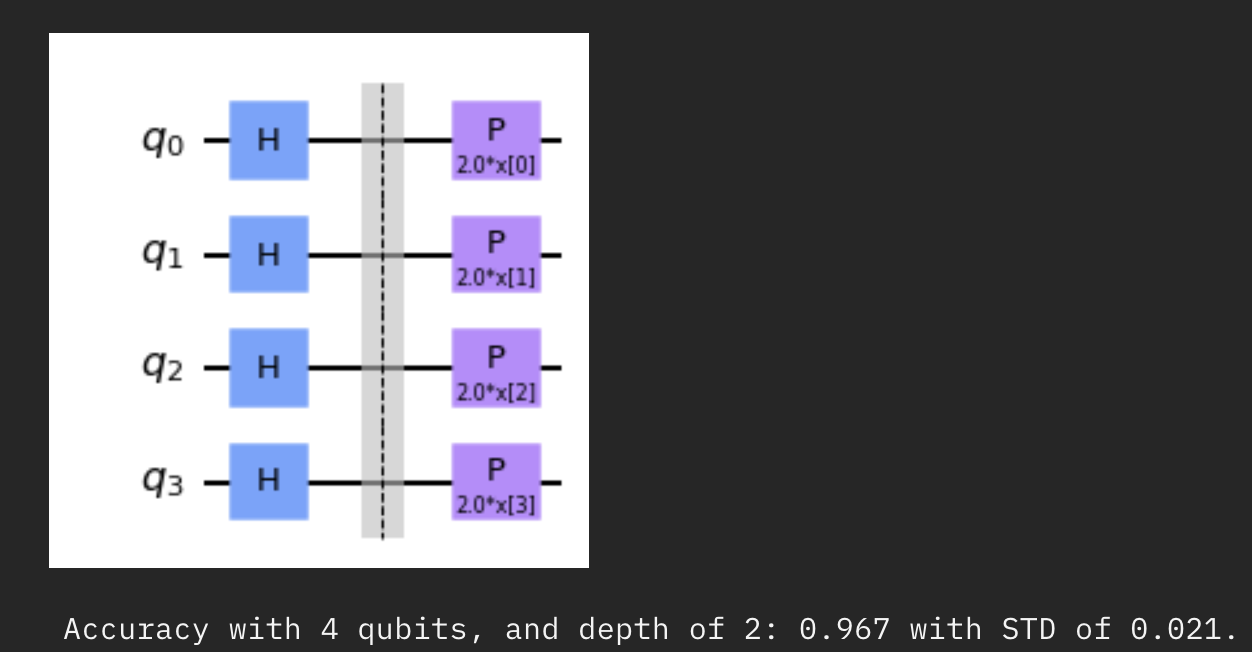

#### **Proposed Kernel**

I am proposing the following AngleEncoding kernel which uses only petal length and width as feature with 2 qubits and depth of 2 - 

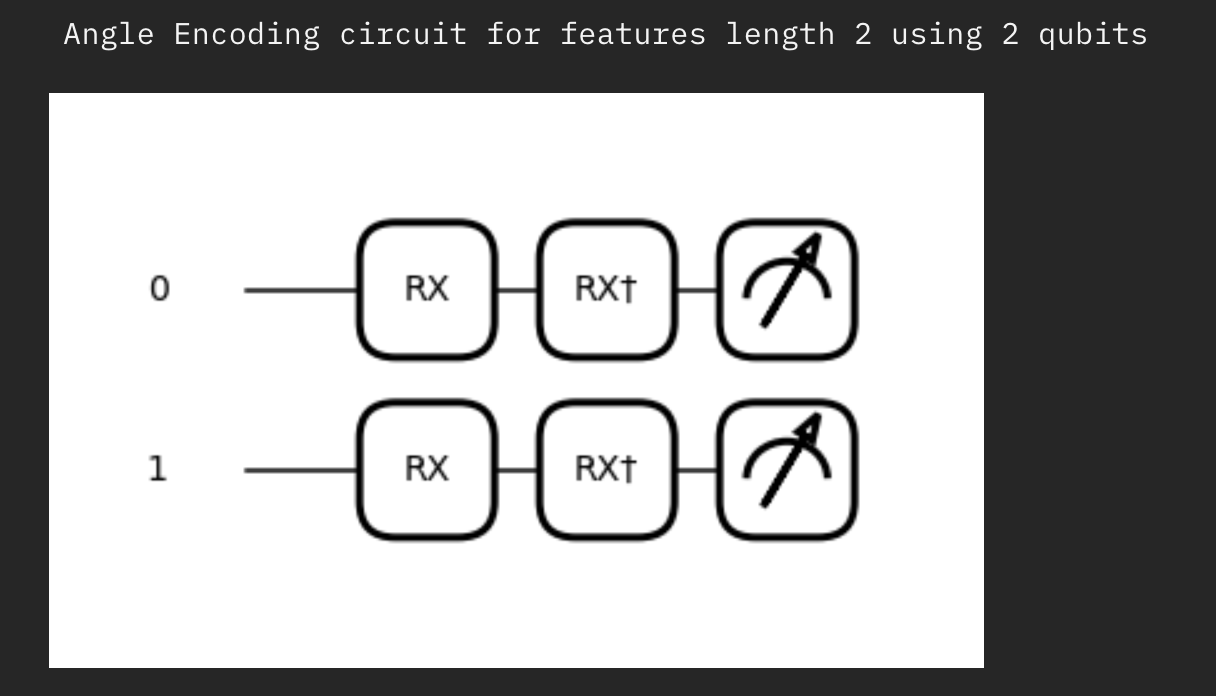

The QSVM model using this kernel yeilds 0.96 as mean accuracy using only 2 qubits and 4 gates with depth of 2. I am selecting this kernel because it's performance is very close to the highest accuracy and it has fewer qubits. 



**NB: At the end of this notebook, a QSVM model has been trained and evaluated using this AngleEncoding kernel and there it has achieved 100% accuracy with 80-20 train-test split.**

## Codes

In [2]:
!pip install -q pennylane
!pip install -q --upgrade scikit-learn
!pip install -q --upgrade imbalanced-learn
!pip install -q qiskit


In [3]:
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, BasicAer
from qiskit.circuit.library import ZZFeatureMap, ZFeatureMap
from qiskit_machine_learning.kernels import QuantumKernel

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score 

import pennylane as qml
from pennylane.templates import AngleEmbedding, AmplitudeEmbedding
# from pennylane.operation import Tensor

import functools
from pennylane import numpy as np

### Description of the dataset

In [4]:
iris_data = load_iris()
features = iris_data.data
labels = iris_data.target

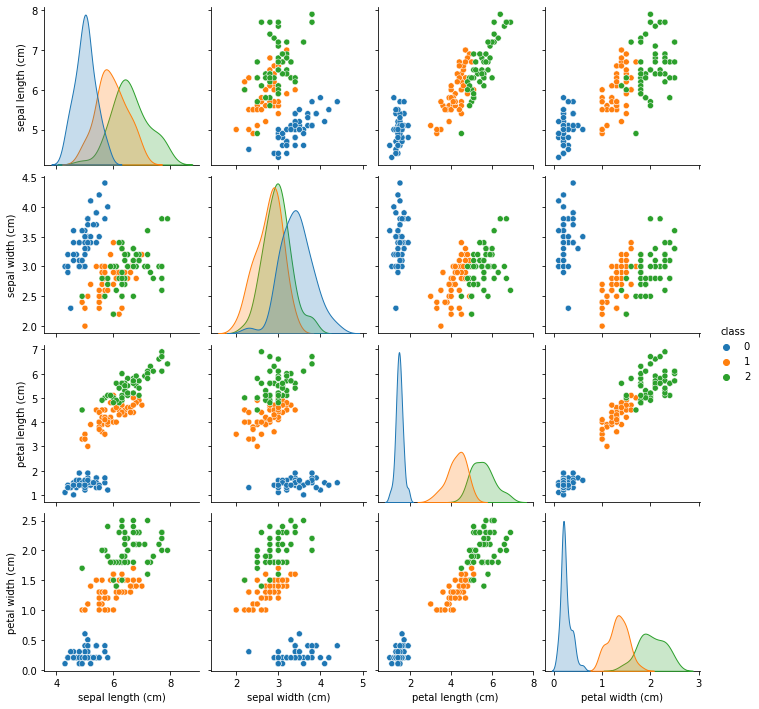

In [5]:
df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

Here we can see that Petal legth and width describes the difference better than Sepal length and width.

In [8]:
features = MinMaxScaler().fit_transform(features)

X_reduced = PCA(2).fit_transform(features)
Xs = [features, features[:, 2:]   ,features[:,:2], X_reduced]
feature_type = ["All Features", "Petal Length & Width as Features", "Sepal Length & Width as Features", "Features reduced by PCA(2)"] 

### Data Encoding using AngleEncoding

In [6]:
def svm_with_angleEncoding(X,cv=2):
    n_qubits = len(X[0])
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    specs_func = qml.specs(kernel, expansion_strategy="device")
    depth = specs_func(X[0], X[0])["depth"]
    
    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])

    svm = SVC(kernel=kernel_matrix, decision_function_shape="ovr")
    scores = cross_val_score(svm, X, labels, cv=cv)    
    
    print( f"Accuracy with {n_qubits} qubits and depth of {depth}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")

# svm_with_angleEncoding(features,2)

In [9]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:") 
    svm_with_angleEncoding(X, 5)

For All Features:
Accuracy with 4 qubits and depth of 2: 0.96 with STD of 0.025. Accuracy Breakdown: [0.933, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:
Accuracy with 2 qubits and depth of 2: 0.96 with STD of 0.025. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.933, 1.0]


For Sepal Length & Width as Features:
Accuracy with 2 qubits and depth of 2: 0.807 with STD of 0.074. Accuracy Breakdown: [0.7, 0.867, 0.733, 0.867, 0.867]


For Features reduced by PCA(2):
Accuracy with 2 qubits and depth of 2: 0.927 with STD of 0.033. Accuracy Breakdown: [0.9, 0.967, 0.9, 0.9, 0.967]




In [10]:
def draw_angleEncoding_circuit(n_features=2):
    n_qubits = n_features
    dev_kernel = qml.device("default.qubit", wires=n_qubits)

    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AngleEmbedding(x1, wires=range(n_qubits))
        qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    
    print(f"Angle Encoding circuit for features length {n_qubits} using {n_qubits} qubits ")
    qml.draw_mpl(kernel, expansion_strategy="device")([np.random.rand() for _ in range(n_qubits)], [np.random.rand() for _ in range(n_qubits)])

Angle Encoding circuit for features length 2 using 2 qubits 


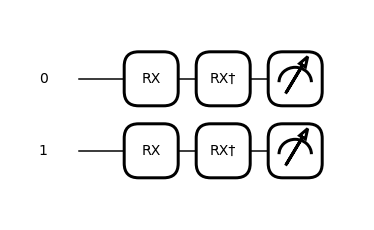

In [11]:
draw_angleEncoding_circuit(2)

Angle Encoding circuit for features length 4 using 4 qubits 


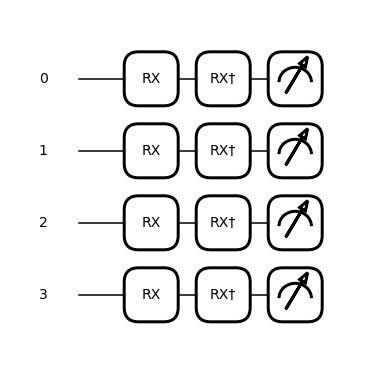

In [12]:
draw_angleEncoding_circuit(4)

### Data Encoding using Amplitude Encoding

In [13]:
def svm_with_amplitudeEncoding(X,cv=5):
    n_qubits = len(X[0]) // 2
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AmplitudeEmbedding(x1, wires=range(n_qubits), normalize = True)
        qml.adjoint(AmplitudeEmbedding)(x2, wires=range(n_qubits), normalize=True)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    
    specs_func = qml.specs(kernel, expansion_strategy="device")
    spec = specs_func(X[0], X[0])
    
    def kernel_matrix(A, B):
        """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
        return np.array([[kernel(a, b) for b in B] for a in A])

    svm = SVC(kernel=kernel_matrix, decision_function_shape="ovr")
    scores = cross_val_score(svm, X, labels, cv=cv)    
    
    print( f"Accuracy with {n_qubits} qubits and depth of {spec['depth']}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")
    
# svm_with_amplitudeEncoding(features, 2)

In [14]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:") 
    svm_with_amplitudeEncoding(X, 5)
    

For All Features:
Accuracy with 2 qubits and depth of 5: 0.773 with STD of 0.102. Accuracy Breakdown: [0.7, 0.8, 0.8, 0.633, 0.933]


For Petal Length & Width as Features:
Accuracy with 1 qubits and depth of 2: 0.64 with STD of 0.053. Accuracy Breakdown: [0.567, 0.6, 0.7, 0.633, 0.7]


For Sepal Length & Width as Features:
Accuracy with 1 qubits and depth of 2: 0.7 with STD of 0.047. Accuracy Breakdown: [0.733, 0.667, 0.633, 0.7, 0.767]


For Features reduced by PCA(2):
Accuracy with 1 qubits and depth of 3: 0.58 with STD of 0.098. Accuracy Breakdown: [0.467, 0.6, 0.467, 0.667, 0.7]




In [15]:
def draw_amplitudeEncoding_circuit(n_features):
    n_qubits = n_features // 2
    dev_kernel = qml.device("default.qubit", wires=n_qubits)
    projector = np.zeros((2**n_qubits, 2**n_qubits))
    projector[0, 0] = 1

    @qml.qnode(dev_kernel)
    def kernel(x1, x2):
        """The quantum kernel."""
        AmplitudeEmbedding(x1, wires=range(n_qubits), normalize = True)
        qml.adjoint(AmplitudeEmbedding)(x2, wires=range(n_qubits), normalize=True)
        return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))
    
    print(f"Angle Amplitude circuit for features length of {n_features} using {n_qubits} qubits ")
    qml.draw_mpl(kernel, expansion_strategy="device")([np.random.rand() for _ in range(n_features)], [np.random.rand() for _ in range(n_features)])


Angle Amplitude circuit for features length of 2 using 1 qubits 


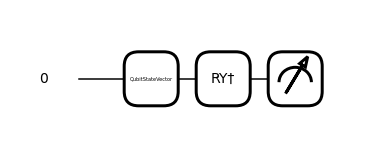

In [16]:
draw_amplitudeEncoding_circuit(2)

Angle Amplitude circuit for features length of 4 using 2 qubits 


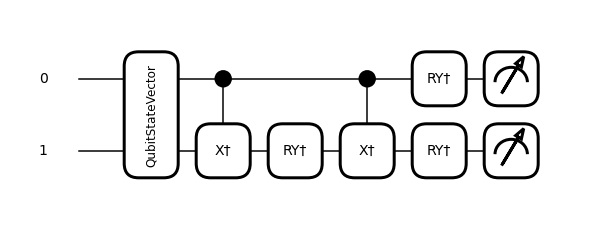

In [17]:
draw_amplitudeEncoding_circuit(4)

### Data encoding using ZZFeatureMap

In [18]:
def qsvm_with_zzfeaturemap(feature_dim, reps, X,cv=5):
    feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=reps, entanglement='linear', insert_barriers=True)
    
    if reps == 1:
        display(feature_map.decompose().draw(output="mpl", fold=20))

    kernel = QuantumKernel(feature_map=feature_map,
                                 quantum_instance=BasicAer.get_backend(
                                                 'statevector_simulator'))
    # Set the SVC algorithm to use our custom kernel
    svc = SVC(kernel=kernel.evaluate, random_state= 42, decision_function_shape="ovr")  # using one-vs-all for multi-class classification
    
  
    
    scores = cross_val_score(svc, X, labels, cv=cv)
    print( f"Accuracy with {feature_dim} qubits, and depth of {feature_map.decompose().depth()}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")
    
    return scores.mean()

# qsvm_with_zzfeaturemap(4, 1, features, 5)

For All Features:


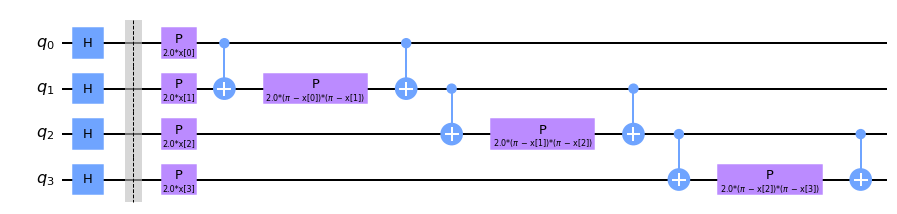

Accuracy with 4 qubits, and depth of 11: 0.967 with STD of 0.021. Accuracy Breakdown: [0.967, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:


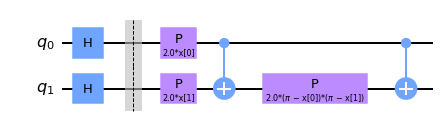

Accuracy with 2 qubits, and depth of 5: 0.96 with STD of 0.025. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.933, 1.0]


For Sepal Length & Width as Features:


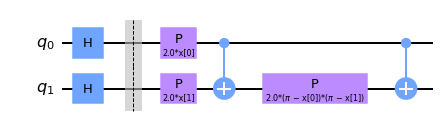

Accuracy with 2 qubits, and depth of 5: 0.8 with STD of 0.047. Accuracy Breakdown: [0.733, 0.833, 0.8, 0.767, 0.867]


For Features reduced by PCA(2):


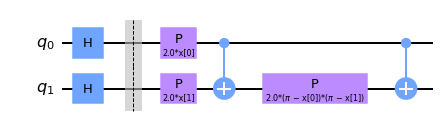

Accuracy with 2 qubits, and depth of 5: 0.92 with STD of 0.034. Accuracy Breakdown: [0.867, 0.933, 0.967, 0.9, 0.933]




In [19]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:") 
    score = qsvm_with_zzfeaturemap(feature_dim = len(X[0]), reps= 1,  X=X , cv =5) # ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


NB: Using multiple reps doesn't show meaningful improvemnt on result.

### Data encoding using ZFeatureMap

In [20]:
def qsvm_with_zfeaturemap(feature_dim, reps, X,cv=5):
    feature_map = ZFeatureMap(feature_dimension=feature_dim, reps=reps, insert_barriers=True)
    
    if reps == 1:
        display(feature_map.decompose().draw(output="mpl", fold=20))

    kernel = QuantumKernel(feature_map=feature_map,
                                 quantum_instance=BasicAer.get_backend(
                                                 'statevector_simulator'))
    # Set the SVC algorithm to use our custom kernel
    svc = SVC(kernel=kernel.evaluate, random_state= 42, decision_function_shape="ovr")  # using one-vs-all for multi-class classification
    
  
    
    scores = cross_val_score(svc, X, labels, cv=cv)
    print( f"Accuracy with {feature_dim} qubits, and depth of {feature_map.decompose().depth()}: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Accuracy Breakdown: {[round(num, 3) for num in scores]}\n\n")
    
    return scores.mean()

# qsvm_with_zzfeaturemap(4, 1, features, 5)

For All Features:


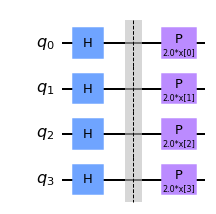

Accuracy with 4 qubits, and depth of 2: 0.967 with STD of 0.021. Accuracy Breakdown: [0.967, 0.967, 0.967, 0.933, 1.0]


For Petal Length & Width as Features:


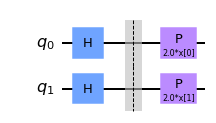

Accuracy with 2 qubits, and depth of 2: 0.953 with STD of 0.034. Accuracy Breakdown: [0.967, 0.967, 0.933, 0.9, 1.0]


For Sepal Length & Width as Features:


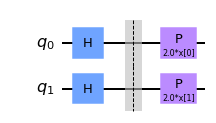

Accuracy with 2 qubits, and depth of 2: 0.807 with STD of 0.049. Accuracy Breakdown: [0.733, 0.833, 0.767, 0.833, 0.867]


For Features reduced by PCA(2):


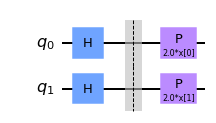

Accuracy with 2 qubits, and depth of 2: 0.953 with STD of 0.034. Accuracy Breakdown: [0.967, 1.0, 0.933, 0.9, 0.967]




In [21]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:") 
    score = qsvm_with_zfeaturemap(feature_dim = len(X[0]), reps= 1,  X=X , cv =5) # ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)


### Classical SVC

In [22]:
for i in range(len(Xs)):
    X = Xs[i]
    label = feature_type[i]
    print(f"For {label}:") 

    
    svc = SVC()
    scores = cross_val_score(svc, X, labels, cv=10)
    print( f"\tAccuracy: {round(scores.mean(), 3)} with STD of {round(scores.std(), 3)}. Acc Breakdown: {[round(num, 3) for num in scores]}")
    
    

For All Features:
	Accuracy: 0.96 with STD of 0.061. Acc Breakdown: [1.0, 0.933, 1.0, 1.0, 0.933, 0.933, 0.8, 1.0, 1.0, 1.0]
For Petal Length & Width as Features:
	Accuracy: 0.96 with STD of 0.044. Acc Breakdown: [1.0, 0.933, 1.0, 0.933, 0.933, 0.933, 0.867, 1.0, 1.0, 1.0]
For Sepal Length & Width as Features:
	Accuracy: 0.78 with STD of 0.085. Acc Breakdown: [0.667, 0.8, 0.867, 0.867, 0.667, 0.667, 0.867, 0.733, 0.8, 0.867]
For Features reduced by PCA(2):
	Accuracy: 0.953 with STD of 0.043. Acc Breakdown: [1.0, 0.933, 1.0, 0.933, 0.933, 0.933, 0.867, 0.933, 1.0, 1.0]


## QSVM with selected AngleEncoding kernel

In [28]:
iris_data = load_iris()

# selecting only petel length and width as feature
features = iris_data.data[:, 2:]
labels = iris_data.target

features = MinMaxScaler().fit_transform(features)
X_train, X_test, y_train, y_test = train_test_split(features, labels, random_state = 42)

In [29]:
n_qubits = 2
dev_kernel = qml.device("default.qubit", wires=n_qubits)
projector = np.zeros((2**n_qubits, 2**n_qubits))
projector[0, 0] = 1

@qml.qnode(dev_kernel)
def kernel(x1, x2):
    """The quantum kernel."""
    AngleEmbedding(x1, wires=range(n_qubits))
    qml.adjoint(AngleEmbedding)(x2, wires=range(n_qubits))
    return qml.expval(qml.Hermitian(projector, wires=range(n_qubits)))


def kernel_matrix(A, B):
    """Compute the matrix whose entries are the kernel evaluated on pairwise data from sets A and B."""
    return np.array([[kernel(a, b) for b in B] for a in A])

svm = SVC(kernel=kernel_matrix, decision_function_shape="ovr")
svm.fit(X_train, y_train) 

score = svm.score(X_test, y_test)

print(f"QSVM classification test score using Angle Encoding: {score}")

QSVM classification test score using Angle Encoding: 1.0


In [31]:
specs_func = qml.specs(kernel, expansion_strategy="device")
spec = specs_func(X_train[0], X_train[0])
print(spec)

{'gate_sizes': defaultdict(<class 'int'>, {1: 4}), 'gate_types': defaultdict(<class 'int'>, {'RX': 2, 'Adjoint(RX)': 2}), 'num_operations': 4, 'num_observables': 1, 'num_diagonalizing_gates': 1, 'num_used_wires': 2, 'depth': 2, 'num_trainable_params': 5, 'num_device_wires': 2, 'device_name': 'default.qubit.autograd', 'expansion_strategy': 'gradient', 'gradient_options': {}, 'interface': 'autograd', 'diff_method': 'best', 'gradient_fn': 'backprop'}
